# Importing the required packages

In [1]:
! pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 22.1 MB/s eta 0:00:00


In [2]:
!pip install torchsummary

In [3]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torchmetrics
from torchsummary import summary
import numpy as np

In [4]:
torch.cuda.is_available()

True

# Importing the CIFAR-10 dataset

In [5]:
import torchvision

trsf_to_tensor = torchvision.transforms.ToTensor()

train_data = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = trsf_to_tensor)
val_data = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = trsf_to_tensor)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


A short visualisation to make sure, that we imported the right dataset:

Number of classes: 10
Image sizes: (32, 32, 3) 



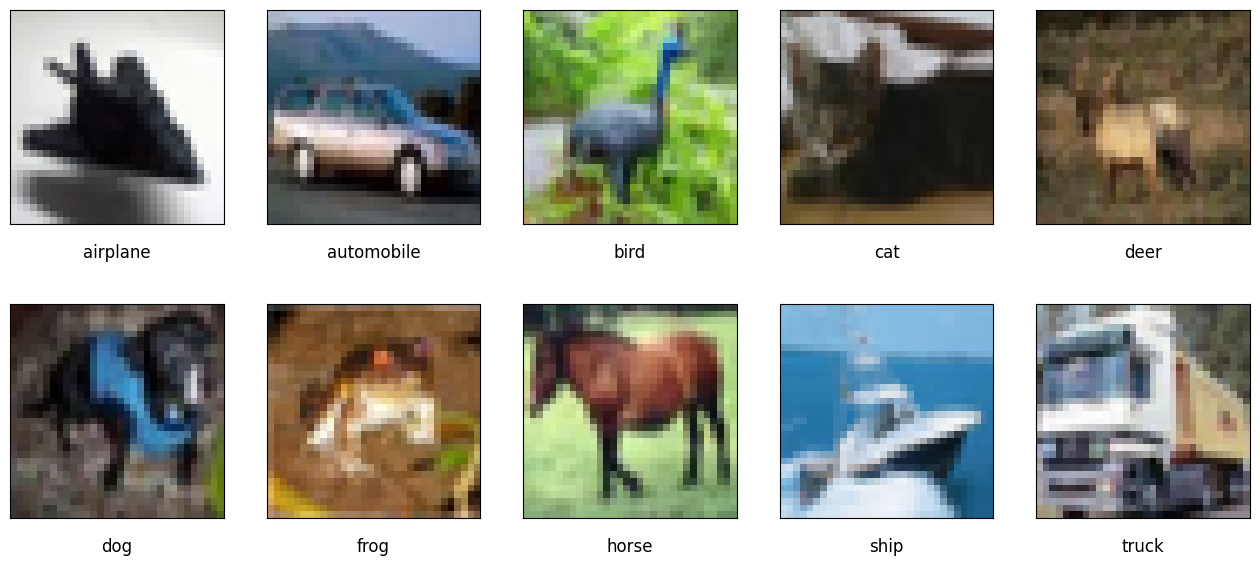

In [6]:
# Visualization

from matplotlib import pyplot as plt

classes = train_data.classes
print(f'Number of classes: {len(classes)}')
print(f'Image sizes: {train_data.data[0].shape}', '\n')

fig, axes = plt.subplots(2, 5, figsize=(16, 7))
for class_idx, class_name in enumerate(classes):
    img_idx = train_data.targets.index(class_idx) # get first instance of the given class
    img_arr = train_data.data[img_idx]
    ax = axes[class_idx // 5, class_idx % 5]
    ax.imshow(img_arr)
    ax.tick_params(left = False, right = False, bottom = False, labelleft = False , labelbottom = False)
    ax.set_title(class_name, y = -0.2)

Generating batches

In [7]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size, shuffle = False)

# Function for training the model

In [8]:
def train(model, train_data, val_data, loss_fn, optimizer, num_classes = 10, num_epochs = 10):

    batch_train_accuracies = []
    epoch_train_accuracies = []
    epoch_val_accuracies = []
    batch_train_loss = []
    batch_val_loss = []
    epoch_train_loss = []
    epoch_val_loss = []
    
    if num_classes == 2:
      task = 'binary'
    elif num_classes > 2:
      task = 'multiclass'
    else:
      raise ValueError('num_classes needs to be an integer greater or equal to 2')

    # Using bulit-in metrics features
    train_accuracy_metric = torchmetrics.Accuracy(task = task, num_classes = num_classes)
    val_accuracy_metric = torchmetrics.Accuracy(task = task, num_classes = num_classes)
    
    model = model.to('cuda')
    softmax = nn.Softmax(dim = 1)
    
    # Training for num_epochs
    for epoch in range(1, num_epochs + 1):
        batch_train_loss = []
        batch_val_loss = []
        
        model.train()

        for x, y in train_data:
            x, y = x.to('cuda'), y.to('cuda')
            
            optimizer.zero_grad()
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            loss.backward()
            optimizer.step()
            
            y_hat = softmax(y_hat).to('cpu')
            
            batch_acc = train_accuracy_metric(y_hat, y.to('cpu'))
            batch_train_accuracies.append(batch_acc)
            batch_train_loss.append(loss.item())
            
        epoch_train_acc = train_accuracy_metric.compute()
        epoch_train_accuracies.append(epoch_train_acc)
        epoch_train_loss.append(np.mean(batch_train_loss))
    
        model.eval()
        for x, y in val_data:
            x, y = x.to('cuda'), y.to('cuda')
            y_hat = model(x)
            loss_val = loss_fn(y_hat, y)
            
            y_hat = softmax(y_hat).to('cpu')
            
            val_accuracy_metric(y_hat, y.to('cpu'))
            batch_val_loss.append(loss_val.item())
        
        val_acc = val_accuracy_metric.compute()
        epoch_val_accuracies.append(val_acc)
        epoch_val_loss.append(np.mean(batch_val_loss))

        

        print(f'Train accuracy at epoch {epoch}: ', epoch_train_acc.numpy())
        print(f'Validation accuracy at epoch {epoch}: ', val_acc.numpy())
        print(f'Train loss at epoch {epoch}: ', np.mean(batch_train_loss))
        print(f'Validation loss at epoch {epoch}: ', np.mean(batch_val_loss))
        print()
    
    model = model.to('cpu')

    # Plotting the results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    ax1.set_title('Accuracies')
    ax1.plot(epoch_train_accuracies, label = 'train'), ax1.plot(epoch_val_accuracies, label = 'validation')
    ax1.grid()
    ax1.legend()

    ax2.set_title('Losses')
    ax2.plot(epoch_train_loss, label = 'train'), ax2.plot(epoch_val_loss, label = 'validation')
    ax2.grid()
    ax2.legend()

    return epoch_train_accuracies, epoch_val_accuracies, epoch_train_loss, epoch_val_loss

# Building the ResNext-50 from scratch

Since there was no more concrete description, I decided to implement the `ResNeXt-50 32x4d` architecture.

In [9]:
import torch
import torch.nn as nn

In [10]:
# Definition of the basic block of the ResNeXt-50 architecture
class resnext_block(nn.Module):
  def __init__(self, in_channels, cardinality, bwidth, idt_downsample=None, stride=1):
    super(resnext_block, self).__init__()
    self.expansion = 2
    out_channels = cardinality * bwidth
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, groups=cardinality, stride=stride, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
    self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
    self.relu = nn.ReLU()
    self.identity_downsample = idt_downsample

  def forward(self, x):
    identity = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.conv3(x)
    x = self.bn3(x)
    
    if self.identity_downsample is not None:
      identity = self.identity_downsample(identity)
            
    x += identity
    x = self.relu(x)
    return x

In [11]:
class ResNeXt(nn.Module):
  def __init__(self, resnet_block, layers, cardinality, bwidth, img_channels, num_classes):
    super(ResNeXt, self).__init__()
    self.in_channels = 64
    self.conv1 = nn.Conv2d(img_channels, 64, kernel_size=7, stride=2, padding=3)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()
    self.cardinality = cardinality
    self.bwidth = bwidth
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
    self.layer1 = self._layers(resnext_block, layers[0], stride=1)
    self.layer2 = self._layers(resnext_block, layers[1], stride=2)
    self.layer3 = self._layers(resnext_block, layers[2], stride=2)
    self.layer4 = self._layers(resnext_block, layers[3], stride=2)
      
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(self.cardinality * self.bwidth, num_classes)


  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)
     
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
       
    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fc(x)
    return x

  def _layers(self, resnext_block, no_residual_blocks, stride):
    identity_downsample = None
    out_channels = self.cardinality * self.bwidth
    layers = []
     
    if stride != 1 or self.in_channels != out_channels * 2:
      identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*2, kernel_size=1, stride=stride), nn.BatchNorm2d(out_channels*2))
       
    layers.append(resnext_block(self.in_channels,  self.cardinality, self.bwidth, identity_downsample, stride))
    self.in_channels = out_channels * 2
      
    for i in range(no_residual_blocks - 1):
      layers.append(resnext_block(self.in_channels, self.cardinality, self.bwidth))
        
    self.bwidth *= 2  
    return nn.Sequential(*layers)

In [12]:
# Defining a function, that returns with an instance of the the ResNeXt-50 (with a default cardinality of 32):
def ResNeXt50(img_channels=3, num_classes=10, cardinality=32, bwidth=4):
    return ResNeXt(resnext_block, [3,4,6,3],  cardinality, bwidth, img_channels, num_classes)

In [13]:
# Let's see the summary of the built model to make sure, that we implemented the right model:
summary(ResNeXt50(), input_size = (3, 128, 128), device = 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,472
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]           8,320
       BatchNorm2d-6          [-1, 128, 32, 32]             256
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]           4,736
       BatchNorm2d-9          [-1, 128, 32, 32]             256
             ReLU-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          33,024
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,640
      BatchNorm2d-14          [-1, 256,

## Training the manually built model for 10 epochs

Train accuracy at epoch 1:  0.19334
Validation accuracy at epoch 1:  0.2667
Train loss at epoch 1:  4.710333138170754
Validation loss at epoch 1:  2.5941061777404593

Train accuracy at epoch 2:  0.25324
Validation accuracy at epoch 2:  0.3085
Train loss at epoch 2:  1.8791115564458511
Validation loss at epoch 2:  1.795985013623781

Train accuracy at epoch 3:  0.29611334
Validation accuracy at epoch 3:  0.34403333
Train loss at epoch 3:  1.6685063345048128
Validation loss at epoch 3:  1.598281750196143

Train accuracy at epoch 4:  0.32923
Validation accuracy at epoch 4:  0.367375
Train loss at epoch 4:  1.551237611514528
Validation loss at epoch 4:  1.529103410394886

Train accuracy at epoch 5:  0.356376
Validation accuracy at epoch 5:  0.3906
Train loss at epoch 5:  1.4615821021292217
Validation loss at epoch 5:  1.4401956177964996

Train accuracy at epoch 6:  0.38004667
Validation accuracy at epoch 6:  0.40791667
Train loss at epoch 6:  1.3814724912423917
Validation loss at epoch 6:  

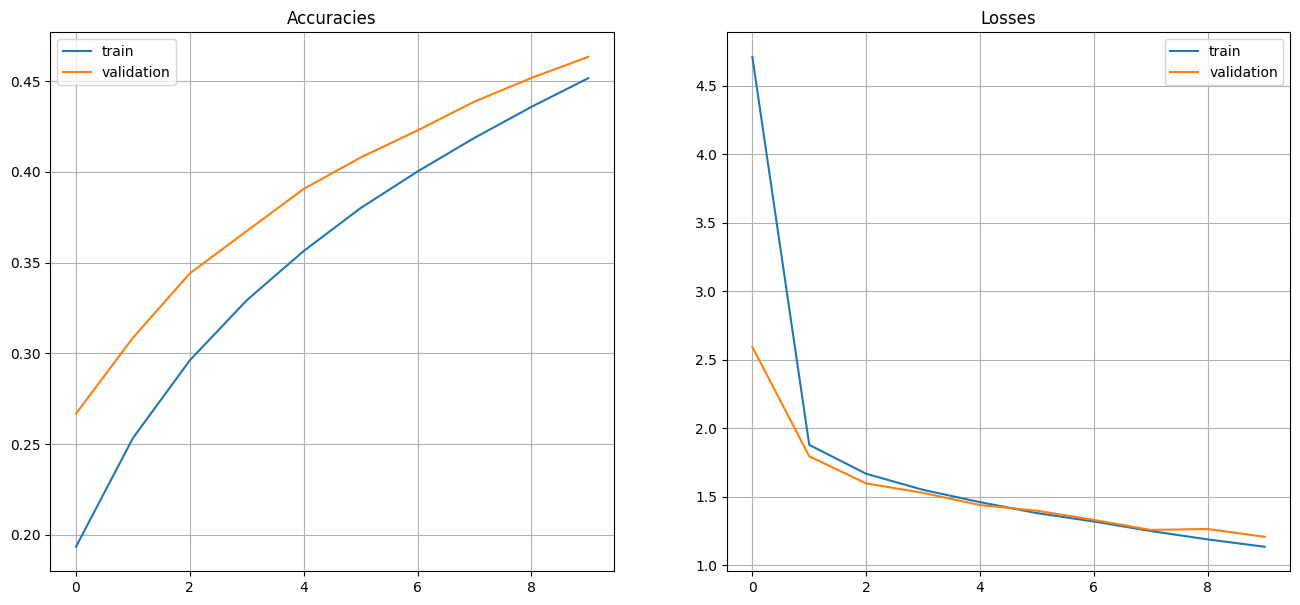

In [14]:
model = ResNeXt50()
optimizer = optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9)
loss = nn.CrossEntropyLoss()

resnext_manual_train_accs, resnext_manual_val_accs, resnext_manual_train_loss, resnext_manual_val_loss = train(model, train_loader, val_loader, loss, optimizer, num_classes = 10, num_epochs = 10)

**Remark:** As expected, it is visible, that the accuracies are increasing as the number of epochs increase and in the meanwhile, the losses are decreasing. It can also be observed, that the accuracy still increases, furthermore overfitting still did not occur and we could get better results if we would increase the number of epochs.

# Pretrained ResNext-50

In [15]:
from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights

In [16]:
pretrained_model = resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /home/jupyter/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth


URLError: <urlopen error [Errno 101] Network is unreachable>

In [ ]:
#print(pretrained_model)

In [ ]:
# Quick check to make sure, that we downloaded the right model:
summary(model = pretrained_model, input_size = (3, 128, 128), device = 'cpu')

Guide how to freeze model parameters:

https://androidkt.com/modify-pre-train-pytorch-model-for-finetuning-and-feature-extraction/

In [ ]:
# Freeze convolutional layers
for param in pretrained_model.parameters():
    param.requires_grad = False

# Modify the final dense layer
num_classes = 10
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = torch.nn.Linear(num_ftrs, num_classes)

In [ ]:
# We want to make sure, that the final dense layer is indeed replaced:  Linear-174 [-1, 1000] ---> Linear-174 [-1, 10]
summary(model = pretrained_model, input_size = (3, 128, 128), device = 'cpu')

## Tuning the final dense layer of the pretrained model

In [ ]:
model = pretrained_model
optimizer = optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9)
loss = nn.CrossEntropyLoss()

resnext_pretrained_train_accs, resnext_pretrained_val_accs, resnext_pretrained_train_loss, resnext_pretrained_val_loss  = train(model, train_loader, val_loader, loss, optimizer, num_classes = 10, num_epochs = 10)

Surprising results: the pretrained model hardly learns. The accuracy stays almost unchanged throughout the training process.

# Comparing the results obtained with the manually built vs. the pretrained model

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

ax1.set_title('Validation accuracies')
ax1.plot(resnext_manual_val_accs, label = 'ResNeXt-50 from scratch'), ax1.plot(resnext_pretrained_val_accs, label = 'ResNeXt-50 pretrained')
ax1.grid()
ax1.legend()

ax2.set_title('Validation losses')
ax2.plot(resnext_manual_val_loss, label = 'ResNeXt-50 from scratch'), ax2.plot(resnext_pretrained_val_loss , label = 'ResNeXt-50 pretrained')
ax2.grid()
ax2.legend()

plt.show()

**Conclusion:** It can be observed, that the pretrained model starts off with a better accuracy, however it hardly learns anything afterwards and it is quickly outperformed by the manually built model (better results already from the 3rd epoch).
The main difference lies in the fact, that the pretrained model has almost all parameters frozen except for the last dense layer, meanwhile the model, which was built from scratch has all of its parameters tuned. Therefore, it would make sense to unfreeze the parameters of the pretrained model and do some finetuning on it.
